In [1]:
# Making necessary imports
# To supress tf warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

For this project, we will be using the text corpus of an ebook ["A Christmas Carol in Prose; Being a Ghost Story of Christmas"](https://www.gutenberg.org/ebooks/46) which is downloaded from Project Gutenberg.

## Data Preparation

In [2]:
with open("../input/a-christmas-carol-in-prose/data.txt", "r", encoding='utf-8-sig') as f:
    text = f.read()
    
# Viewing a portion of the original text
text[:500]

'The Project Gutenberg eBook of A Christmas Carol, by Charles Dickens\n\nThis eBook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this eBook or online at\nwww.gutenberg.org. If you are not located in the United States, you\nwill have to check the laws of the country where you are located before\nusing'

In [3]:
# Some basic preprocessing

text = " ".join(text.split()) # Remove any remaining white spaces
text = text.replace('"', '').replace("'", '') # Remove single and double quotation marks

# Viewing a portion of the preprocessed text
text[:500]

'The Project Gutenberg eBook of A Christmas Carol, by Charles Dickens This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using '

In [4]:
# Apply Tokenization

# Fitting tokenizer on text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

# View what the tokenizer has learned
vocab_size = len(tokenizer.word_index)+1
print(f'Total number of unique words: {vocab_size}\n')
print(f"Word Count: {list(tokenizer.word_counts.items())[:5]}\n")
print(f"Document Count: {tokenizer.document_count}\n")
print(f"Word Index: {dict(list(tokenizer.word_index.items())[:5])}")

# Saving the tokenizer
pickle.dump(tokenizer, open("./tokenizer.pkl", 'wb'))

Total number of unique words: 4701

Word Count: [('the', 1761), ('project', 88), ('gutenberg', 97), ('ebook', 13), ('of', 783)]

Document Count: 1

Word Index: {'the': 1, 'and': 2, 'of': 3, 'a': 4, 'to': 5}


In [5]:
# Transforming text to sequences
sequence_data = tokenizer.texts_to_sequences([text])[0]
print(f'Length of sequence data: {len(sequence_data)}')
print(sequence_data[:5])

Length of sequence data: 32050
[1, 51, 46, 304, 3]


In [6]:
# Creating sequences each having 4 words (first three words are used to predict the fourth word)
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)

sequences = np.array(sequences)
print(f'Total number of sequences: {sequences.shape[0]}')
sequences[:5]

Total number of sequences: 32047


array([[  1,  51,  46, 304],
       [ 51,  46, 304,   3],
       [ 46, 304,   3,   4],
       [304,   3,   4,  50],
       [  3,   4,  50, 505]])

In [7]:
# Taking first 3 words as input and last word as output

X = sequences[:,0:3]
y = sequences[:,3]

# Converting output into binary class matrix
y = to_categorical(y, num_classes=vocab_size)
y[:5]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building & Training

In [8]:
# Creating a LSTM model

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 10)             47010     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 4701)              4705701   
Total params: 17,801,711
Trainable params: 17,801,711
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Training the model

checkpoint = ModelCheckpoint("./model.h5", monitor="loss", verbose=1, save_best_only=True)

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(X_train,
          y_train,
          epochs=100,
          batch_size=64,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint])

Epoch 1/100
401/401 [==============================] - 10s 15ms/step - loss: 6.7525 - accuracy: 0.0521 - val_loss: 6.5872 - val_accuracy: 0.0529

Epoch 00001: loss improved from inf to 6.75254, saving model to ./model.h5
Epoch 2/100
401/401 [==============================] - 5s 13ms/step - loss: 6.2891 - accuracy: 0.0608 - val_loss: 6.5330 - val_accuracy: 0.0619

Epoch 00002: loss improved from 6.75254 to 6.28907, saving model to ./model.h5
Epoch 3/100
401/401 [==============================] - 5s 13ms/step - loss: 6.0055 - accuracy: 0.0721 - val_loss: 6.5417 - val_accuracy: 0.0778

Epoch 00003: loss improved from 6.28907 to 6.00548, saving model to ./model.h5
Epoch 4/100
401/401 [==============================] - 5s 13ms/step - loss: 5.6892 - accuracy: 0.0883 - val_loss: 6.5626 - val_accuracy: 0.0875

Epoch 00004: loss improved from 6.00548 to 5.68919, saving model to ./model.h5
Epoch 5/100
401/401 [==============================] - 5s 13ms/step - loss: 5.3902 - accuracy: 0.1043 - val

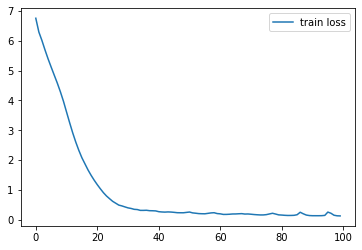

<Figure size 432x288 with 0 Axes>

In [10]:
# Plotting losses and accuracies on each epochs

# loss
plt.plot(history.history['loss'], label='train loss')
plt.legend()
plt.show()
plt.savefig('loss')

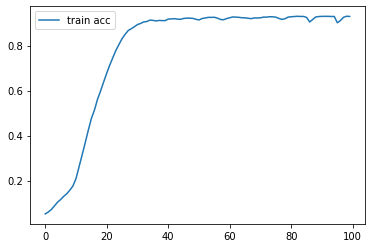

<Figure size 432x288 with 0 Axes>

In [11]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('accuracy')

## Predicting

In [12]:
# Uncomment this cell to test out the model

# # Loading the saved tokenizer and model
# tokenizer = pickle.load(open('./tokenizer.pkl', 'rb'))
# model = load_model('./model.h5')

# def predict_next_word(text, tokenizer=tokenizer, model=model):
#     sequence = tokenizer.texts_to_sequences([text])
#     sequence = np.array(sequence)
#     preds = np.argmax(model.predict(sequence))
#     word = list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(preds)]
#     return word

# while True:
#     text = input("Enter your sentence here: ")
#     if text == "break":
#         break
    
#     words = text.split()
#     if len(words)<3:
#         print("Input sentence should have minimum 3 words")
#         continue
#     word = predict_next_word(words[-3:])
#     print(f"Prediction: {word}")